### Procesamiento imagenes SAR empleando transformers

Se emplearon 2 arquitecturas para la restauracion de imagenes y reduccion de ruido implementando los siguientes papers:

- [Restormer: Efficient Transformer for High-Resolution Image Restoration](https://arxiv.org/pdf/2111.09881)
- [Uformer: A General U-Shaped Transformer for Image Restoration](https://openaccess.thecvf.com/content/CVPR2022/papers/Wang_Uformer_A_General_U-Shaped_Transformer_for_Image_Restoration_CVPR_2022_paper.pdf)

El archivo tiene la siguiente arquitectura:

- [Restormer](#Restormer)

  - [Entrenamiento](#r-entrenamiento)
  - [Cargar Modelo](#r-modelo)
  - [Inferecias](#r-inferencias)
  - [Metricas](#r-metricas)

- [Uformer](#Uformer)

  - [Entrenamiento](#u-entrenamiento)
  - [Inferecias](#u-inferencias)
  - [Metricas](#u-metricas)

- [Metricas comparativas](#metricas-comparativas)
- [Test](#test)


In [2]:
from IPython.display import HTML

HTML("""<style>
.column {
  float: left;
  width: 50%;
}

/* Clear floats after the columns */
.row:after {
  content: "";
  display: table;
  clear: both;
}
</style>
<div class="row">
  <div class="column"><iframe src=../references/Wang_Uformer_A_General_U-Shaped_Transformer_for_Image_Restoration_CVPR_2022_paper.pdf width=700 height=700></iframe></div>
  <div class="column"><iframe src=../references/2111.09881v2.pdf width=700 height=700></div>
</div>""")

# Variable de la carpeta principal


In [1]:
import os
from pathlib import Path

def cambiar_directorio(path, destino):
    """
    This Python function `cambiar_directorio` is designed to change
    the current working directory to a specified destination directory
    within the given path. Here's a breakdown of what the function does:

    Args:
        path (_type_): Ruta de carpeta hija
        destino (_type_): nombre de carpeta padre a buscar
    """
    # Obtener el directorio actual
    directorio_actual = os.getcwd()

    # Verificar si el directorio actual es el destino
    if directorio_actual.endswith(destino):
        print(f"Ya estamos en la carpeta {destino}")
        return

    # Separar el directorio actual en componentes
    componentes = directorio_actual.split(os.sep)

    # Verificar si el destino es un subdirectorio del actual
    if destino in componentes:
        # Construir el path del destino
        path_destino = os.sep.join(componentes[: componentes.index(destino) + 1])

        # Cambiar al directorio destino
        os.chdir(path_destino)
        print(f"Directorio cambiado a {path_destino}")
    else:
        # Subir un nivel y repetir
        os.chdir("..")
        cambiar_directorio(path, destino)

print("Actual path: ", os.getcwd())

cambiar_directorio(
    path=os.getcwd(),
    destino="transformers",
)

print("New path: ", os.getcwd())
root_folder = os.getcwd()

Actual path:  /home/bdebian/Documents/Projects/app_denoise_images/pytorch_env/transformers/src/notebooks
Directorio cambiado a /home/bdebian/Documents/Projects/app_denoise_images/pytorch_env/transformers
New path:  /home/bdebian/Documents/Projects/app_denoise_images/pytorch_env/transformers


# Restormer


![alt text](../../references/restormer.png)


### Entrenamiento <a id='r-entrenamiento'></a>

Los parametros de configuracion estan ubicados en el siguiente archivo:

- [Configuracion](../data/config/config.yml)

La siguiente celda es la encargada de ejecutar el entrenamiento del modelo **Restormer**. ⚠️ Solo se debe de manipular el archivo _config.yaml_.

```yaml
# general settings
...
...
num_gpu: 1 # ----> Cambiar a 0 si se va a emplear CPU
...
...
preprocessing:
  image-path-raw: "ruta de la carpeta que contiene las carpetas con las imagenes GTruth y Noisy"
  output: "ruta de la carpeta que contiene las carpetas de imagenes aumentadas GTruth y Noisy"
  train-split-percentage: 0.8 # ---->  indica que el 80% de las imágenes del conjunto de datos se utilizarán para entrenar el modelo de machine learning. El 20% restante se reservará para evaluar el rendimiento del modelo en datos que no ha visto durante el entrenamiento.
...
...
datasets:
  train:
    prefetch_mode: cuda # para GPU usar cuda, si se va a entrenar sin GPU usar cpu
...
...
path:
  pretrain_network_g: Ruta del modelo pre-entrenado(...basicsr/gaussian_gray_denoising_blind.pth)
  ...
  resume_state: ~ # Ruta del ultimo estado que se quiere usar para continuar el entrenamiento
  experiments_root: Ruta donde se guardan archivos temporales durante el entrenamiento(.../src/visualization/temp)
  ...
  models: Ruta donde se guardaran los modelos de entramiento (.../src/data/model)
  training_states: Ruta donde se guardan los estados del entrenamiento ["metadata"] (.../src/data/model/training_states)
  ...
  ...
  ...
train:
  ...
  ...
  ...
  pixel_opt:
      type: PSNRLoss # Configuracion del tipo de perdida con el cual se va a entrenar el modelo, se pueden usar PSNRLoss, CharbonnierLoss y L1Loss
  ...
  ...
```


Cuando se ejecuta esta celda, se inicia el entrenamiento.

In [ ]:
import os

wd = os.getcwd()
os.chdir("../../")
%run basicsr/train.py
os.chdir(wd)

## Cargar Modelo Entrenado <a id='r-modelo'></a>

Los modelos que se pueden emplear en esta celda deben de estar previamente entrenados y contar con unas de las siguientes perdidas:
- PSNR
- CHARBONNIER
- L1LOSS

```python
class ModelsName(str, Enum):
    """Clase Enum para escoger tipo de perdida para el modelo Restormer"""
    PSNR = "PSNR"
    CHARBONNIER = "CharbonierLoss"
    L1LOSS = "L1Loss_0_99"

"""Cargar de la siguiente manera, ecoger solo una perdida."""
# Ejemplo PSRN
model_name = ModelsName.PSNR.value
# Charbonnier
model_name = ModelsName.CHARBONNIER.value
# L1LOSS
model_name = ModelsName.L1LOSS.value


weights, parameters = get_weights_and_parameters(model_name)
```


**PSNR (Peak Signal-to-Noise Ratio)**

- El PSNR se calcula como el logaritmo base 10 de la relación entre la máxima potencia posible de la señal y la potencia del ruido de fondo. Matemáticamente, se expresa como:

$ PSNR = 10 \log\_{10}( \frac{\text{MAX PIXEL VALUE}^2 }{MSE} ) $

Donde:

- MAX PIXEL VALUE es el valor máximo posible para un píxel (por ejemplo, 255 para imágenes de 8 bits)
- MSE es el error cuadrático medio (Mean Squared Error) entre las imágenes original y reconstruida

Ventajas:

- Fácil de interpretar y comprender.
- Ampliamente utilizada y aceptada en la comunidad de investigación de imágenes.

Desventajas:

- Sensible a cambios en la luminosidad global de la imagen.
- No tiene en cuenta la percepción visual humana.

**Charbonnier Loss**

La función de pérdida Charbonnier, también conocida como " pérdida robusta de L1", es una alternativa al PSNR que ofrece mayor robustez a valores atípicos (outliers) en los datos. En lugar de penalizar linealmente los errores, la pérdida Charbonnier aplica una penalización suave, lo que la hace menos sensible a picos de ruido.

$ CharbonnierLoss = \alpha \cdot \sqrt{(x^2 + \epsilon^2)} + (1 - \alpha) \cdot L1\_{Loss}(x) $

Donde:

- x es la diferencia entre los valores de píxeles correspondientes en las imágenes original y reconstruida
- alpha es un factor de ponderación entre la penalización suave y la penalización L1 (típicamente entre 0 y 1)
- epsilon es un pequeño valor positivo que evita la división por cero

Ventajas:

- Robusta a valores atípicos en los datos.
- Puede producir imágenes con mayor nitidez y detalles.

Desventajas:

- Cálculo ligeramente más complejo que el PSNR.
- La elección del parámetro alpha puede afectar significativamente el resultado.

**L1 Loss (L1 Loss)**

La función de pérdida L1 (L1 Loss), también conocida como "pérdida absoluta", es una medida simple y directa de la diferencia entre los valores de píxeles correspondientes en las imágenes original y reconstruida. Se calcula como la suma de los valores absolutos de las diferencias de píxeles.

La función de pérdida L1 se define como:

$ L1\_{Loss} = sum(abs(x)) $

Donde:

- x es la diferencia entre los valores de píxeles correspondientes en las imágenes original y reconstruida
- abs() es la función valor absoluto

Ventajas:

- Cálculo simple y eficiente.
- Robusta a valores atípicos en los datos.

Desventajas:

- No tiene en cuenta la percepción visual humana.
- Puede producir imágenes borrosas o con artefactos.


Celda en la cual se genera la funcion para obtener los pesos de los diferentes modelos entrenados.
*__Solo correr esta celda, no se debe de modificar nada.__*

In [172]:
import torch
import torch.nn.functional as F
from runpy import run_path
import cv2
from tqdm import tqdm
import numpy as np
from pathlib import Path
import os
from enum import Enum


# Cambiar cantidad de epoca de los pesos
def get_weights_and_parameters(
	model: str,
	folder_weigths: Path | str
) -> dict[str, list[Path] | list[int]]:
	"""Funcion para cambiar pesos cada modelo

	Args:
		model (str): Nombre del modelo que se desea cambiar
		folder_weigths (Path | str): Ruta de la carpeta donde se encuentra el modelo

	Returns:
		dict[str, list[Path] | list[int]]: Diccionario con la lista de modelos disponibles para ejecutar
	"""
	# Si se quiere correr otro modelo se requiere cambiar el path
	models = {
		"CharbonierLoss": {
			"weights_available": (weights_available := list(range(4000, 88000, 4000))),
			"path": [
				# Path(f"{folder_weigths}/CharbonierLoss/net_g_{w}.pth")
				Path(f"{folder_weigths}/net_g_{w}.pth")
				for w in weights_available
			],
		},
		"L1Loss_0_99": {
			"weights_available": (weights_available := list(range(4000, 84000, 4000))),
			"path": [
				# Path(f"{folder_weigths}/L1Loss_0_99/net_g_{w}.pth")
				Path(f"{folder_weigths}/net_g_{w}.pth")
				for w in weights_available
			],
		},
		"PSNR": {
			"weights_available": (weights_available := list(range(4000, 104000, 4000))),
			"path": [
				# Path(f"{folder_weigths}/PSNR/net_g_{w}.pth") 
				Path(f"{folder_weigths}/net_g_{w}.pth") 
				for w in weights_available
			],
		},
	}

	return models[model]

## Seleccion de la perdida del modelo junto con directorios de carpetas

#### __Importante__ : modificar la variables `folder_weigths_root` cuando se cambie de modelo indicando la ruta adecuada donde se almacenan en memoria

In [184]:
class ModelsName(str, Enum):
    """Clase Enum para escoger tipo de perdida para el modelo Restormer"""

    PSNR = "PSNR"
    CHARBONNIER = "CharbonierLoss"
    L1LOSS = "L1Loss_0_99"


# Este es el valor a modificar segun lo explicado anteriormente
model_name = ModelsName.PSNR.value


# RUTA DE LOS PESOS DEL MODELO RESTORMER
folder_weigths_root = "/mnt/data extra/modelos_sar/restormer/psnr/Modelos"

# RUTA DE LA CARPETA CON IMAGENES GROUND TRUTH
gt_dir = "/mnt/data extra/modelos_sar/images/Ground Truth"

# RUTA DE LA CARPETA CON IMAGENES NOISY
noisy_dir = "/mnt/data extra/modelos_sar/images/Noisy"

imagenes_a_predecir = Path("/mnt/data extra/modelos_sar/images/Imagenes para prediccion")
imagenes_a_predecir.mkdir(exist_ok=True,parents=True)


# Ruta donde se almacena los archivos de salida tanto imagenes como metricas
out_dir = Path("/mnt/data extra/modelos_sar/output/inference")
out_dir = out_dir.joinpath(f"{model_name}/images").as_posix()

### __Definicion de rutas de pesos y scripts__

- __folder_weigths_root__ : Ruta donde se encuetran los pesos para el modelo de Restormer
- __model_path_root__ : Ruta donde se encuentra el script de ejecucion para cargar la arquitectura del modelo


In [185]:
parameters = {
	"inp_channels": 1,
	"out_channels": 1,
	"dim": 48,
	"num_blocks": [4, 6, 6, 8],
	"num_refinement_blocks": 4,
	"heads": [1, 2, 4, 8],
	"ffn_expansion_factor": 2.66,
	"bias": False,
	"LayerNorm_type": "BiasFree",
	"dual_pixel_task": False,
}

weights = get_weights_and_parameters(model_name, folder_weigths_root)

# Cargar arquitectura del modelo
model_path_root = Path(root_folder).joinpath("basicsr").as_posix()
load_arch = run_path(
	os.path.join(model_path_root, "models", "archs", "restormer_arch.py")
)
model = load_arch["Restormer"](**parameters)
if torch.cuda.is_available():
  model.cuda()
else:
  model.cpu()

### Inferecias <a id='r-inferencias'></a>
Generacion de imagenes restauradas (menor ruidos)

_Definicion de rutas_

- __gt_dir__ : Directorio donde se almacenas las imagenes Ground Truth para validacion
- __noisy_dir__ : Directorio donde se almacenan las imagenes con Ruido o en su defecto sobre las cuales de hacen las predicciones
- __out_dir__ : Directorio donde se almacenan la salida del modelo, tanto las imagenes como las metricas

Si se requiere calcular las metricas poner en `True` la variable metrics_flag. Esta variable por defecto se encuentra en `True`.
Nota: 
Seleccionar el nombre de las imagenes que desea hacer la inferencia, estas imagenes deben de existir en las carpetas __src/data/validation_data_report__ y __src/images__

In [19]:
from src.lib.class_load import LoadFiles
hd_loadfile = LoadFiles()

file_names, files_path = hd_loadfile.search_load_files_extencion(
    path_search=imagenes_a_predecir.as_posix(), ext=["tiff"])['tiff']
display(file_names)

['5632_11776',
 '5120_20480',
 '5120_3072',
 '0_1024',
 '5120_17408',
 '5632_25088',
 '5120_24064',
 '5632_7680',
 '5632_18944',
 '5120_20992',
 '5120_19968',
 '5120_19456',
 '5120_1536',
 '5120_512']

In [186]:
from numpy import float64
from collections import defaultdict
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import mean_squared_error as mse
import json

os.makedirs(out_dir, exist_ok=True)

# Listado de imagenes seleccionadas en base al paper
# files = ["2560_22016_Tokyo", "2560_23552_Tokyo", "0_512", "0_1024", "0_1536"]
files = file_names

img_multiple_of = 8
metrics_flag = True

metrics = defaultdict(list[dict[str, float | str | float64]])
with torch.no_grad():
    for weight, index in zip(weights["path"], weights["weights_available"]):
        checkpoint = torch.load(weight)
        model.load_state_dict(checkpoint["params"])
        model.eval()

        for filepath in tqdm(files):
            torch.cuda.ipc_collect()
            torch.cuda.empty_cache()
            im_path: Path = Path(noisy_dir).joinpath(filepath).with_suffix(".tiff")
            og = cv2.imread(im_path.as_posix(), -1)
            img = cv2.cvtColor(og, cv2.COLOR_BGR2GRAY)
            img_ = np.reshape(img, (512, 512, 1))
            if torch.cuda.is_available():
                input_ = (
                    torch.from_numpy(img_).float().permute(2, 0, 1).unsqueeze(0).cuda()
                )
            else:
                input_ = torch.from_numpy(img_).float().permute(2, 0, 1).unsqueeze(0).cpu()
            h, w = input_.shape[2], input_.shape[3]
            H, W = (
                ((h + img_multiple_of) // img_multiple_of) * img_multiple_of,
                ((w + img_multiple_of) // img_multiple_of) * img_multiple_of,
            )
            padh = H - h if h % img_multiple_of != 0 else 0
            padw = W - w if w % img_multiple_of != 0 else 0
            input_ = F.pad(input_, (0, padw, 0, padh), "reflect")
            restored = model(input_)

            # Unpad the output
            restored = restored[:, :, :h, :w]
            restored = restored.permute(0, 2, 3, 1).cpu().detach().numpy()
            restored = np.squeeze(restored[0])

            max_retormer = np.max(restored)
            min_retormer = np.min(restored)
            
            if metrics_flag:
                val_im_path: Path = Path(gt_dir).joinpath(filepath).with_suffix(".tiff")
                val_og = cv2.imread(val_im_path.as_posix(),-1)
                val_img = cv2.cvtColor(val_og, cv2.COLOR_BGR2GRAY)

                metrics[f"model_{index}"].append({
                f"file_{filepath}": "",
                "psnr": psnr(val_img.astype(np.float32), restored, data_range=max_retormer - min_retormer),
                "ssim": ssim(val_img.astype(np.float32), restored, data_range=max_retormer - min_retormer),
                "mse": mse(val_img.astype(np.float32), restored)
                })

            filename = os.path.split(gt_dir)[-1]
            cv2.imwrite(os.path.join(out_dir, f"{filepath}_{index}.png"), restored)


# Ruta para guardar metricas 
save_dir_metrics = Path(out_dir).joinpath("metricas")
save_dir_metrics.mkdir(exist_ok=True,parents=True)
save_dir_metrics = save_dir_metrics.joinpath(model_name).with_suffix(".json")

json.dump(metrics,save_dir_metrics.open("w"))

100%|██████████| 14/14 [00:07<00:00,  1.80it/s]


### Metricas <a id='r-metricas'></a>


En la siguiente celda se calcula cual es el mejor modelo entrenado segun la perdida escogida. Para poder ejecutar esta celda se debe de haber ejecutado la anterior celda con la bandera metrics_flag en `True`.

In [323]:
def calculate_best_model(data):
	"""
	Analyzes a JSON structure containing model performance data and identifies
	the model with the best overall performance based on:
	    - Lowest PSNR (Peak Signal-to-Noise Ratio)
	    - Highest SSIM (Structural Similarity Index Measure)
	    - Lowest MSE (Mean Squared Error)

	Args:
	    data (dict): A dictionary representing the JSON data containing
	                 model performance information.

	Returns:
	    str: The name of the model with the best overall performance.
	"""

	best_model = None
	best_score = float("inf")  # Initialize with positive infinity

	for model_name, model_data in data.items():
		for entry in model_data:
			score = entry["psnr"] + (1 - entry["ssim"]) + entry["mse"]
			# Combine PSNR, SSIM (inverted), and MSE into a single score

			if score < best_score:
				best_model = model_name
				best_score = score

	return best_model


metrics = json.load(save_dir_metrics.open("r"))
print(calculate_best_model(metrics))

model_20000


# Uformer


![alt text](../../Uformer/fig/Uformer.png)


### Entrenamiento <a id='u-entrenamiento'></a>

_Ruta para ejecucion_

- train_workers : "Ruta de las imagenes Ground Truth"
- val_dir: "Ruta de la imagenes Noisy",
- gpu: Numero de la GPU para ejecucion, por defecto empieza en la posicion cero

Ejecutar siguiente celda para realizar el entramiento del UFormer.

In [ ]:
train_dir ="/mnt/data extra/modelos_sar/output/inference/L1Loss_0_99/images/metricas"
val_dir = "/home/arthemis/Documents/pytorch_env/pytorch_env/transformers_ruben/src/data/transformed_data/val"

In [ ]:
import os

wd = os.getcwd()
os.chdir("../Uformer")
! poetry run train/train_denoise.py --train_dir "{train_dir}" --gpu 0 --val_dir "{val_dir}"
os.chdir(wd)

### Inferecias <a id='u-inferencias'></a>


_Ruta para ejecucion_

- input_dir : "Ruta de las imagenes Noisy"
- result_dir: "Ruta donde se guardan las imagenes",
- weights: Ruta de los pesos del modelo entrenado en la celda anterior

En la siguiente celda se realiza la inferencia de las imagenes. ⚠️ Para ejecutar esta celda es necesario tener una GPU.


## Rutas para hacer inferencia

In [67]:
# Ruta de la carpeta con la imagenes para predicciones
input_dir_uformer = imagenes_a_predecir.as_posix()

# Ruta de la carpeta donde se guardan la predicciones
result_dir = "/mnt/data extra/modelos_sar/output/inference_uformer"

# Ruta donde se encuentra los pesos del modelo
weights = "/mnt/data extra/modelos_sar/Uformer/model_best.pth"

In [66]:
import os

from PIL import Image
def convertir_tiff_a_png(ruta_tiff, ruta_png):
    """
    Convierte una imagen TIFF a PNG.

    Parámetros:
    ruta_tiff (str): Ruta del archivo TIFF.
    ruta_png (str): Ruta donde se guardará el archivo PNG.
    """
    try:
        # Abrir la imagen TIFF
        imagen = Image.open(ruta_tiff)

        # Convertir a PNG y guardar
        imagen.save(ruta_png, "PNG")

        print(f"Imagen convertida con éxito: {ruta_png}")
    except Exception as e:
        print(f"Error al convertir la imagen: {e}")

# Ejemplo de uso
for image_name in files_path:
    name_convert = Path(image_name).with_suffix(".png")
    convertir_tiff_a_png(image_name, name_convert)

wd = os.getcwd()
os.chdir("Uformer")
! poetry run python3 test/test_dnd.py --input_dir "{input_dir_uformer}" --result_dir "{result_dir}" --weights "{weights}"
os.chdir(wd)

Imagen convertida con éxito: /mnt/data extra/modelos_sar/images/Imagenes para prediccion/5632_11776.png
Imagen convertida con éxito: /mnt/data extra/modelos_sar/images/Imagenes para prediccion/5120_20480.png
Imagen convertida con éxito: /mnt/data extra/modelos_sar/images/Imagenes para prediccion/5120_3072.png
Imagen convertida con éxito: /mnt/data extra/modelos_sar/images/Imagenes para prediccion/0_1024.png
Imagen convertida con éxito: /mnt/data extra/modelos_sar/images/Imagenes para prediccion/5120_17408.png
Imagen convertida con éxito: /mnt/data extra/modelos_sar/images/Imagenes para prediccion/5632_25088.png
Imagen convertida con éxito: /mnt/data extra/modelos_sar/images/Imagenes para prediccion/5120_24064.png
Imagen convertida con éxito: /mnt/data extra/modelos_sar/images/Imagenes para prediccion/5632_7680.png
Imagen convertida con éxito: /mnt/data extra/modelos_sar/images/Imagenes para prediccion/5632_18944.png
Imagen convertida con éxito: /mnt/data extra/modelos_sar/images/Imagen

### Metricas <a id='u-metricas'></a>

En la siguiente celda se calculan las metricas del modelo Uformer. \
Para ejecutar esta celda se deben de tener las imagenes inferidas por la celda anterior. \
Para el calculo de metricas se tiene que contar tanto con las imagenes groundtruth y las imagenes inferidas por el modelo 

In [78]:
# Ruta donde se encuentran las imagenes GrounTruth
images_gt = "/mnt/data extra/modelos_sar/images/Ground Truth"

# Ruta donde se encuentra las predicciones en png 
inference_dir = '/mnt/data extra/modelos_sar/output/inference_uformer/png'

# Ruta donde se van a guardar la metricas de uformter
save_metric_ = Path('/mnt/data extra/modelos_sar/output/inference_uformer/').joinpath('metrics').with_suffix('.json')


In [77]:
import os
from pathlib import Path
import cv2
import numpy as np
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import mean_squared_error as mse
from collections import defaultdict
from numpy import float64
from tqdm import tqdm
from src.lib.class_load import LoadFiles

def metrics(
	gt_dir = f"{root_folder}/src/data/validation_data_report",
	inference_dir = f"{root_folder}/Uformer/results/denoising/DND/png",
	files: list[str] = ["0_1024", "5120_19456", "5120_19968", "5120_20480"],
	save_metric : str = None,
):
    """
    gt_dir

    inference_dir

    files
    """
    metrics_uformer = defaultdict(list[dict[str, float | str | float64]])
    for filepath in tqdm(files):
        im_path = Path(gt_dir).joinpath(filepath).with_suffix(".tiff")
        og = cv2.imread(im_path.as_posix(), -1)
        img = cv2.cvtColor(og, cv2.COLOR_BGR2GRAY)
        # img_ = np.reshape(img, (512, 512, 1))
        restored_img = Path(inference_dir).joinpath(filepath).with_suffix('.png')
        restored = cv2.imread(restored_img.as_posix(), -1)
        restored = cv2.cvtColor(restored, cv2.COLOR_BGR2GRAY)
        # restored = np.reshape(img, (512, 512, 1))
        max_retormer: float = np.max(restored)
        min_retormer: float = np.min(restored)
        metrics_uformer["model"].append(
            {
                f"file_{filepath}": "",
                "psnr": psnr(
                    img.astype(np.float32),
                    restored,
                    data_range=max_retormer - min_retormer,
                ),
                "ssim": ssim(
                    img.astype(np.float32),
                    restored,
                    data_range=max_retormer - min_retormer,
                ),
                "mse": mse(img.astype(np.float32), restored),
            }
        )

    with open(save_metric, "w") as json_file:
        json.dump(metrics_uformer, json_file)

hd_loadfile = LoadFiles()

file_names, files_path = hd_loadfile.search_load_files_extencion(
    path_search=imagenes_a_predecir.as_posix(), ext=["tiff"])['tiff']


metrics(
    gt_dir=images_gt,
    inference_dir=inference_dir,
    files=file_names,
    save_metric=save_metric_.as_posix(),
)

100%|██████████| 14/14 [00:00<00:00, 50.06it/s]


# Graficas de metricas

## Metricas Restormer

In [188]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Rutas donde se almacenaron los archivos de las metricas para se graficadas
path_charbonier = "/mnt/data extra/modelos_sar/output/inference/CharbonierLoss/images/metricas/CharbonierLoss.json"
path_psnr = "/mnt/data extra/modelos_sar/output/inference/PSNR/images/metricas/PSNR.json"
path_L1_loss = "/mnt/data extra/modelos_sar/output/inference/L1Loss_0_99/images/metricas/L1Loss_0_99.json"

,modelo,file,psnr,ssim,mse
0,model_4000,file_5632_11776,21.360697,0.600414,283.564000
1,model_4000,file_5120_20480,22.387626,0.669144,181.434613
2,model_4000,file_5120_3072,20.799232,0.639343,371.764489
3,model_4000,file_0_1024,20.711038,0.638694,403.960848
4,model_4000,file_5120_17408,23.789555,0.639850,183.623861
...,...,...,...,...,...
289,model_84000,file_5120_20992,25.458209,0.659006,136.846821
290,model_84000,file_5120_19968,25.177257,0.755755,157.833708
291,model_84000,file_5120_19456,24.982005,0.703927,153.526091
292,model_84000,file_5120_1536,23.411722,0.619585,192.038718


,modelo,file,psnr,ssim,mse
0,model_4000,file_5632_11776,0.780084,0.600414,0.342492
1,model_4000,file_5120_20480,0.817587,0.669144,0.219139
2,model_4000,file_5120_3072,0.759579,0.639343,0.449022
3,model_4000,file_0_1024,0.756359,0.638694,0.487909
4,model_4000,file_5120_17408,0.868785,0.639850,0.221783
...,...,...,...,...,...
289,model_84000,file_5120_20992,0.929723,0.659006,0.165285
290,model_84000,file_5120_19968,0.919463,0.755755,0.190634
291,model_84000,file_5120_19456,0.912333,0.703927,0.185431
292,model_84000,file_5120_1536,0.854986,0.619585,0.231947


/tmp/ipykernel_128256/3530507252.py:58: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[row, col].set_xticklabels(plto.get_xticklabels(), rotation=45)
/tmp/ipykernel_128256/3530507252.py:58: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[row, col].set_xticklabels(plto.get_xticklabels(), rotation=45)
/tmp/ipykernel_128256/3530507252.py:58: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[row, col].set_xticklabels(plto.get_xticklabels(), rotation=45)
/tmp/ipykernel_128256/3530507252.py:58: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[row, col].set_xticklabels(plto.get_xticklabels(), rotation=45)
/tmp/ipykernel_128256/3530507252.py:58: UserWarn

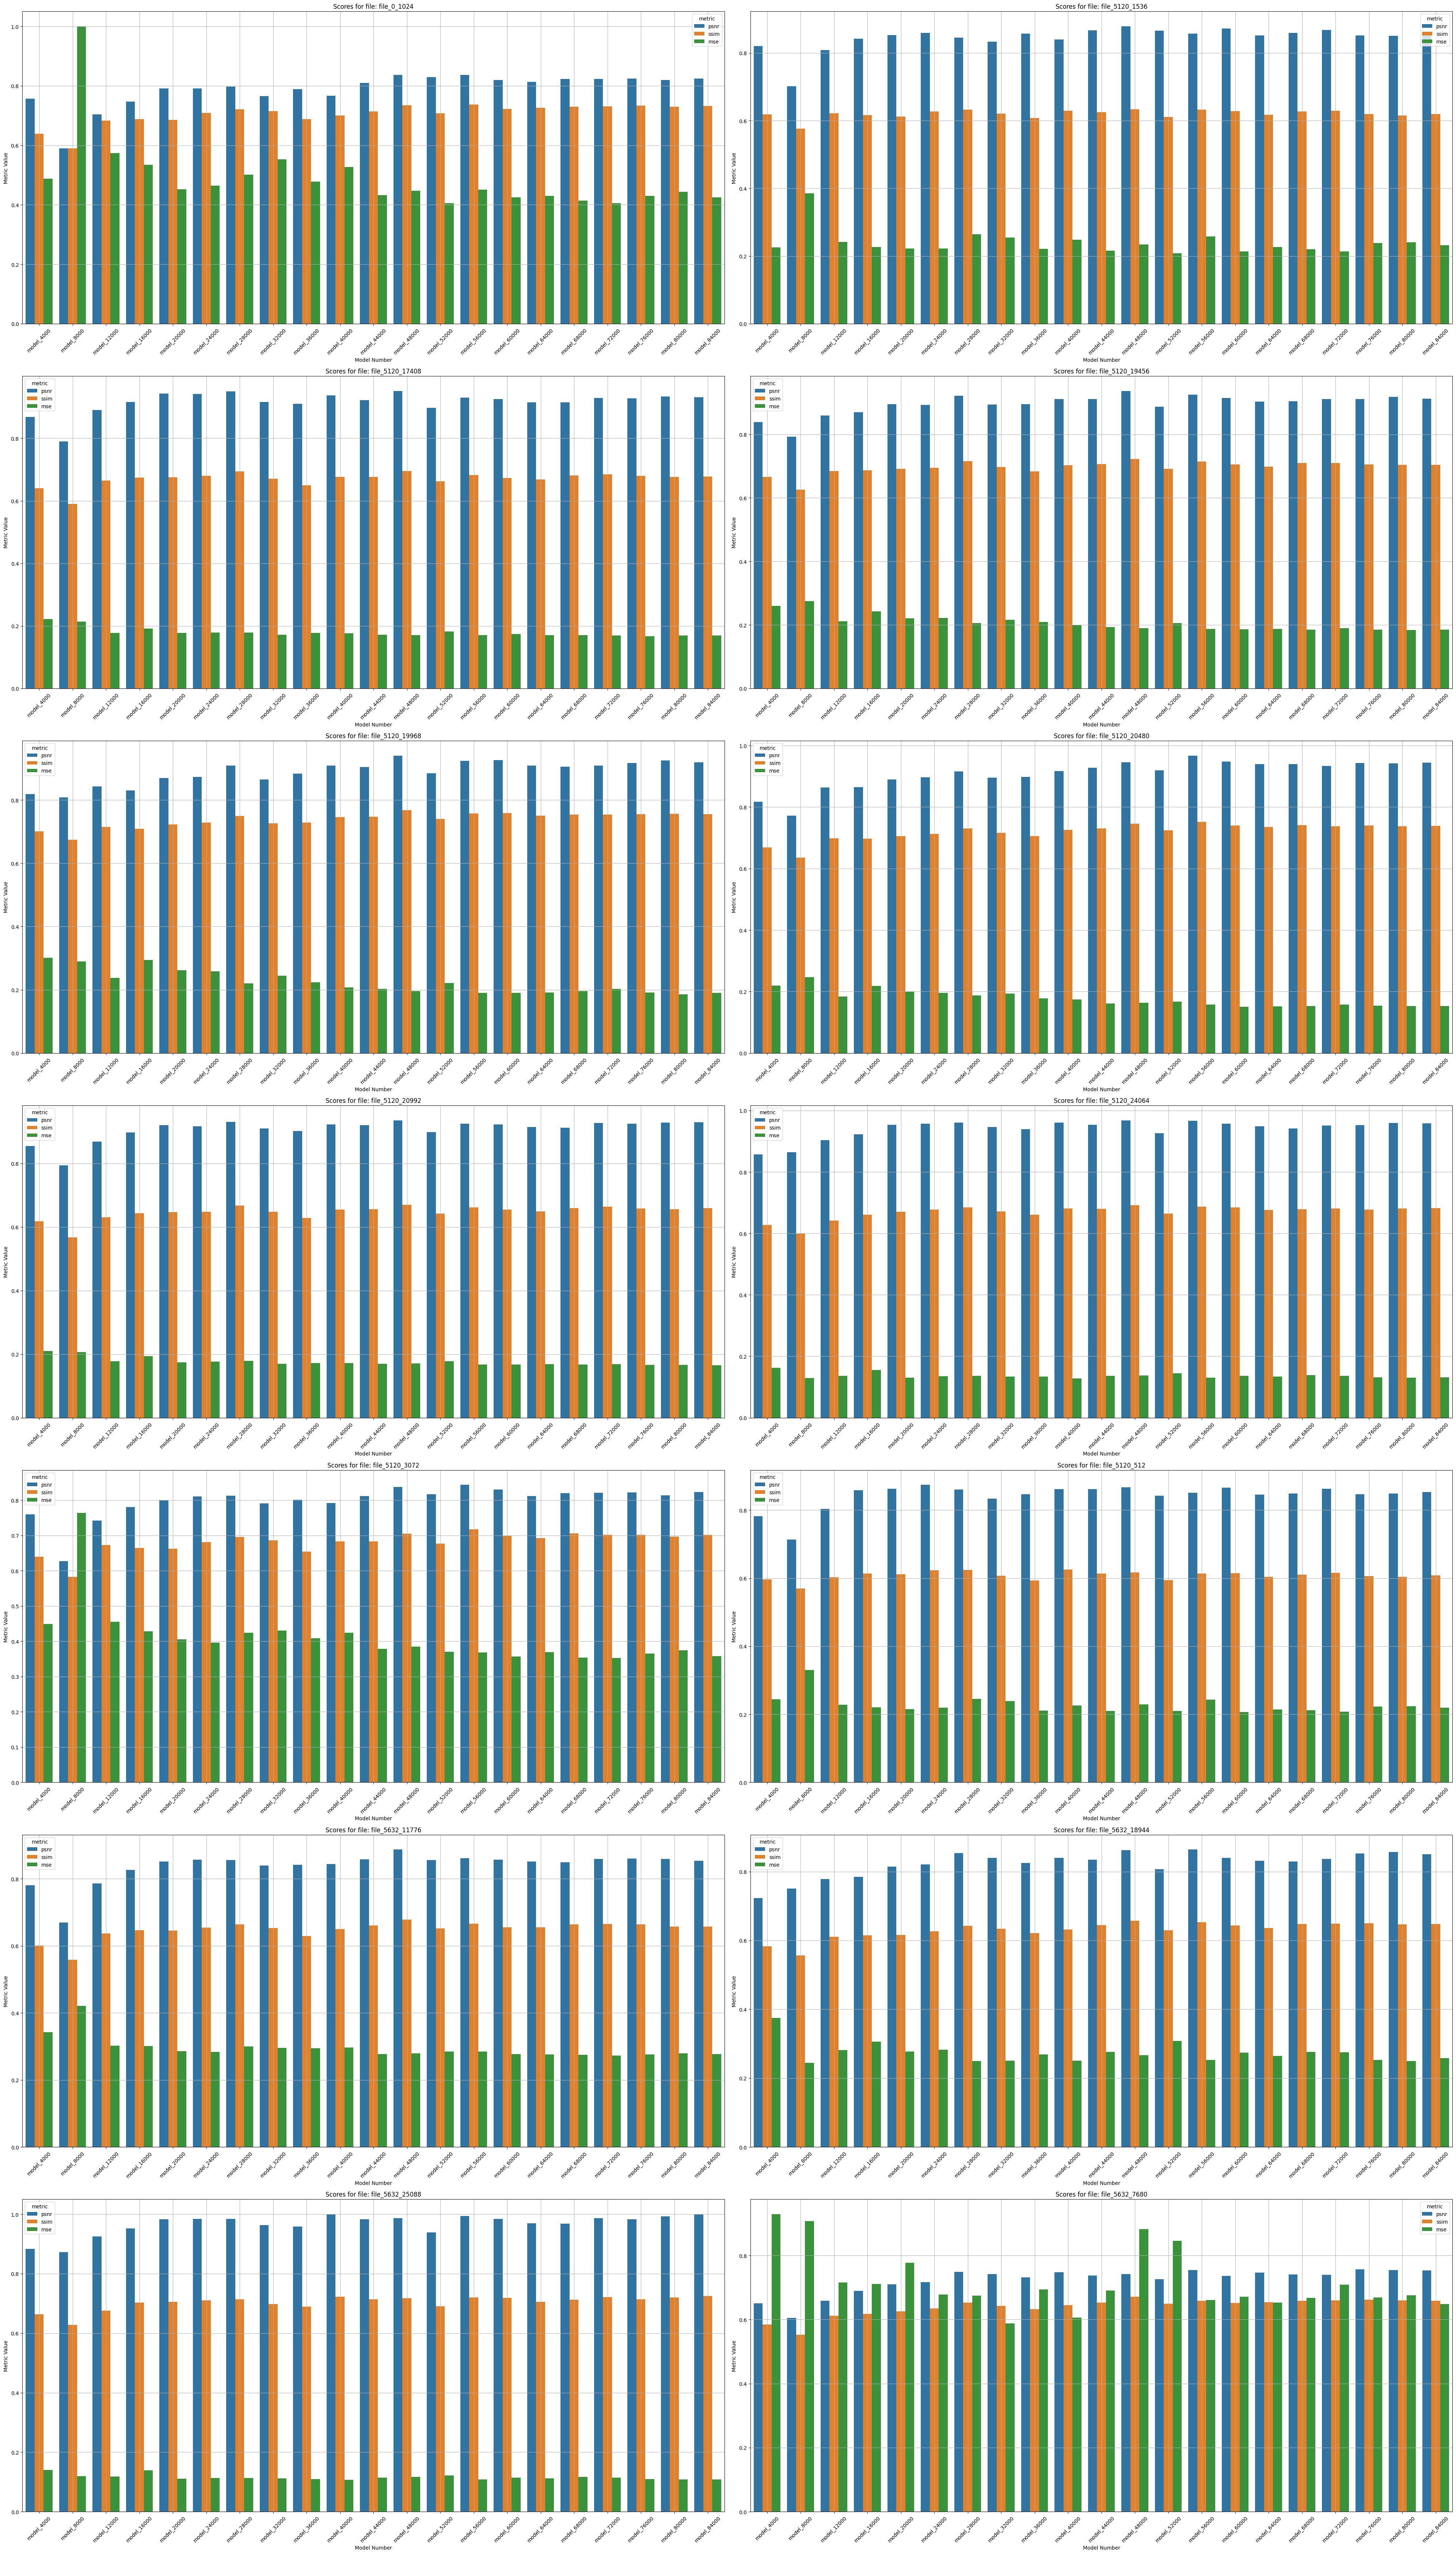

In [319]:
metricas_charbonier = hd_loadfile.json_to_dict(path_charbonier)[0]
print("El mejor modelo en base a la optimizacion de las metricas es : ",calculate_best_model(metricas_charbonier))

model_data = []
for name_model,data in metricas_charbonier.items():
    temp_dict_uf = {}
    for items_metric in data:
        list_key_data = list(items_metric.keys())
        temp_dict_rst = {}
        temp_dict_rst = {
            "modelo": name_model,
            "file": list_key_data[0],
            list_key_data[1]: items_metric[list_key_data[1]],
            list_key_data[2]: items_metric[list_key_data[2]],
            list_key_data[3]: items_metric[list_key_data[3]],
        }

        model_data.append(temp_dict_rst)


charbo_pd = pd.DataFrame(model_data)
display(charbo_pd)

scale_col = ["psnr", "mse"]
for column in scale_col:
    charbo_pd[column] = charbo_pd[column] / charbo_pd[column].abs().max()

display(charbo_pd)

grouped = charbo_pd.groupby("file")
# Definir el número de filas y columnas para la cuadrícula
num_rows = 7  # Ajusta según el número de archivos
num_cols = 2  # Ajusta según el número de archivos

# Crear una figura con subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(40, 70))

# Iterar sobre cada grupo de 'file' y crear un gráfico en un subplot específico
row = 0
col = 0
for file, group in grouped:
    # Reshape los datos para que sean adecuados para seaborn
    group_melted = group.melt(
        id_vars=["modelo"],
        value_vars=["psnr", "ssim", "mse"],
        var_name="metric",
        value_name="value",
    )

    # Crear el gráfico de barras en el subplot correspondiente
    plto = sns.barplot(
        x="modelo", y="value", hue="metric", data=group_melted, ax=axes[row, col]
    )

    # Personalizar el gráfico
    axes[row, col].set_title(f"Scores for file: {file}")
    axes[row, col].set_xlabel("Model Number")
    axes[row, col].set_ylabel("Metric Value")
    axes[row, col].set_xticklabels(plto.get_xticklabels(), rotation=45)
    axes[row, col].grid()

    # Incrementar los índices de fila y columna
    col += 1
    if col >= num_cols:
        row += 1
        col = 0

# Ajustar el espaciado entre los subplots
plt.tight_layout()

# Mostrar la figura
plt.show()

,modelo,file,psnr,ssim,mse
0,model_4000,file_5632_11776,20.713333,0.637880,423.353568
1,model_4000,file_5120_20480,22.474849,0.700983,237.614923
2,model_4000,file_5120_3072,19.726602,0.695448,617.664783
3,model_4000,file_0_1024,18.392463,0.689965,800.721504
4,model_4000,file_5120_17408,23.578413,0.678874,249.862612
...,...,...,...,...,...
345,model_100000,file_5120_20992,25.016572,0.653576,136.829126
346,model_100000,file_5120_19968,25.259908,0.755940,168.350555
347,model_100000,file_5120_19456,24.844709,0.705786,155.682558
348,model_100000,file_5120_1536,23.092422,0.614721,185.851976


,modelo,file,psnr,ssim,mse
0,model_4000,file_5632_11776,0.751682,0.637880,0.315049
1,model_4000,file_5120_20480,0.815607,0.700983,0.176827
2,model_4000,file_5120_3072,0.715874,0.695448,0.459650
3,model_4000,file_0_1024,0.667458,0.689965,0.595877
4,model_4000,file_5120_17408,0.855655,0.678874,0.185941
...,...,...,...,...,...
345,model_100000,file_5120_20992,0.907846,0.653576,0.101825
346,model_100000,file_5120_19968,0.916676,0.755940,0.125282
347,model_100000,file_5120_19456,0.901609,0.705786,0.115855
348,model_100000,file_5120_1536,0.838019,0.614721,0.138306


/tmp/ipykernel_128256/433066403.py:57: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[row, col].set_xticklabels(plto.get_xticklabels(), rotation=45)
/tmp/ipykernel_128256/433066403.py:57: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[row, col].set_xticklabels(plto.get_xticklabels(), rotation=45)
/tmp/ipykernel_128256/433066403.py:57: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[row, col].set_xticklabels(plto.get_xticklabels(), rotation=45)
/tmp/ipykernel_128256/433066403.py:57: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[row, col].set_xticklabels(plto.get_xticklabels(), rotation=45)
/tmp/ipykernel_128256/433066403.py:57: UserWarning: 

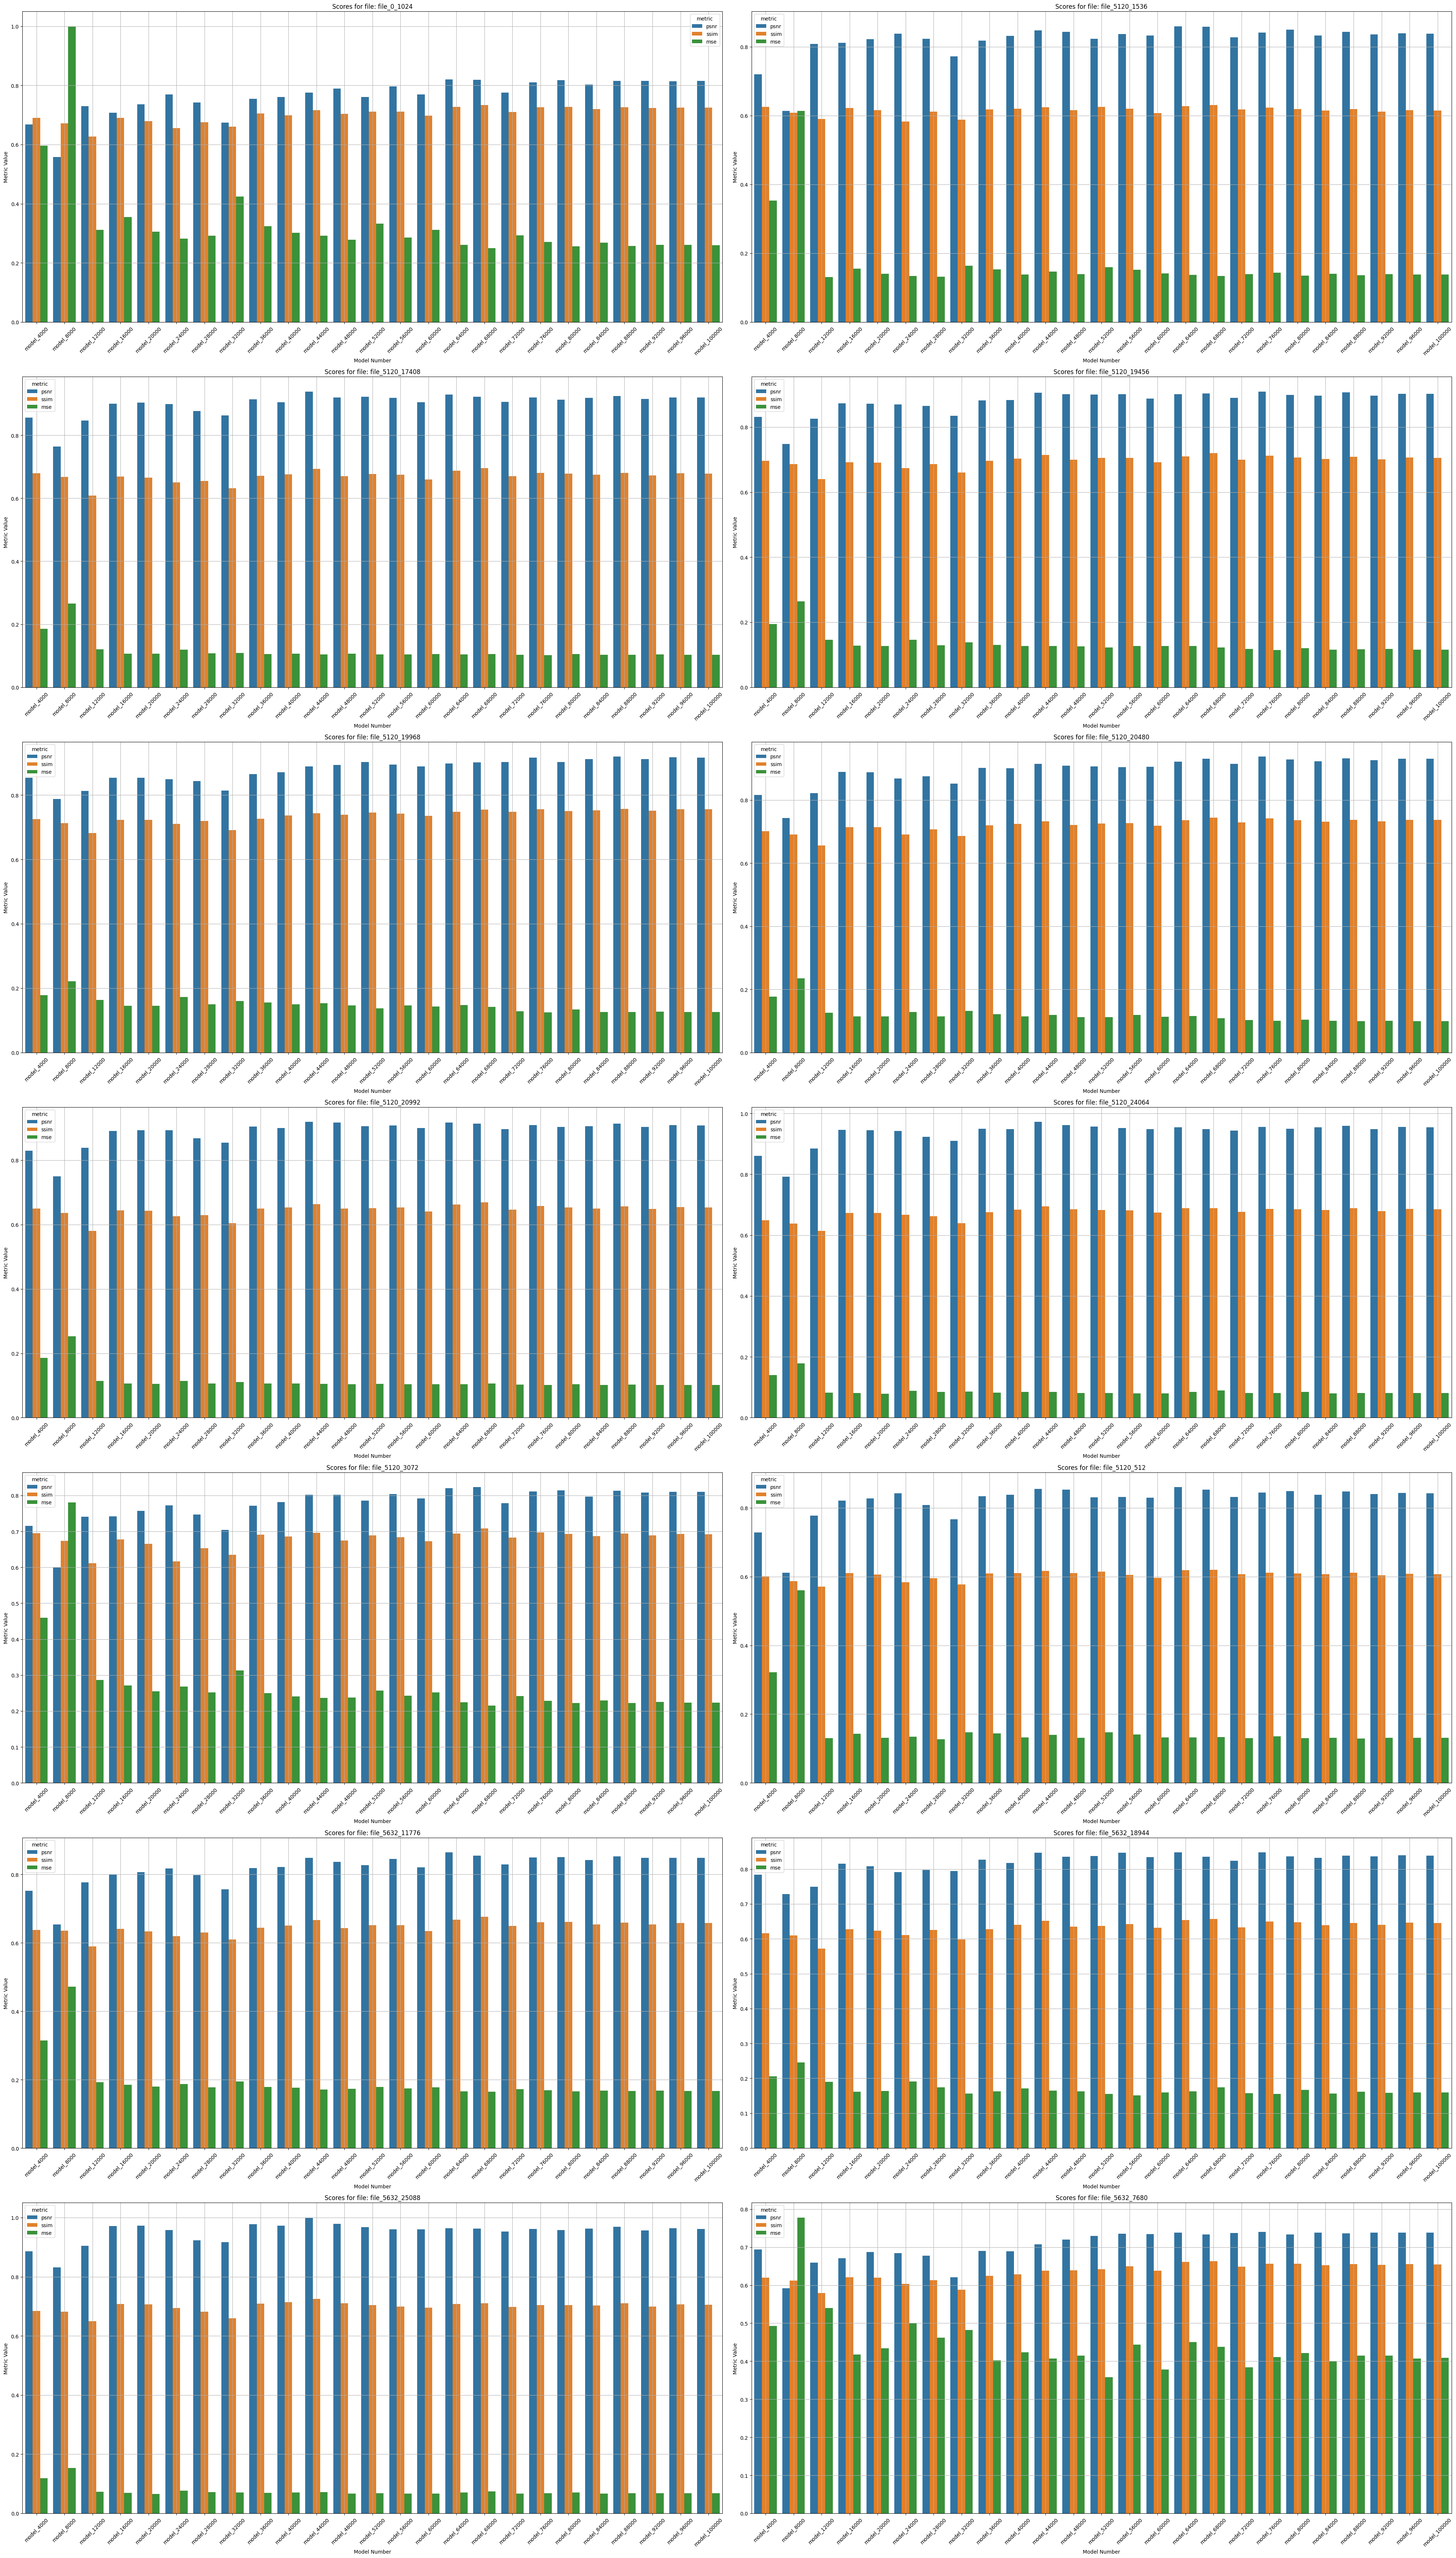

In [320]:
metricas_psnr = hd_loadfile.json_to_dict(path_psnr)[0]
print(
    "El mejor modelo en base a la optimizacion de las metricas es : ",
    calculate_best_model(metricas_psnr),
)

model_data = []
for name_model, data in metricas_psnr.items():
    temp_dict_uf = {}
    for items_metric in data:
        list_key_data = list(items_metric.keys())
        temp_dict_rst = {}
        temp_dict_rst = {
            "modelo": name_model,
            "file": list_key_data[0],
            list_key_data[1]: items_metric[list_key_data[1]],
            list_key_data[2]: items_metric[list_key_data[2]],
            list_key_data[3]: items_metric[list_key_data[3]],
        }

        model_data.append(temp_dict_rst)


charbo_pd = pd.DataFrame(model_data)
display(charbo_pd)

scale_col = ["psnr", "mse"]
for column in scale_col:
    charbo_pd[column] = charbo_pd[column] / charbo_pd[column].abs().max()

display(charbo_pd)

grouped = charbo_pd.groupby("file")
# Definir el número de filas y columnas para la cuadrícula
num_rows = 7  # Ajusta según el número de archivos
num_cols = 2  # Ajusta según el número de archivos

# Crear una figura con subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(40, 70))

# Iterar sobre cada grupo de 'file' y crear un gráfico en un subplot específico
row = 0
col = 0
for file, group in grouped:
    # Reshape los datos para que sean adecuados para seaborn
    group_melted = group.melt(
        id_vars=["modelo"],
        value_vars=["psnr", "ssim", "mse"],
        var_name="metric",
        value_name="value",
    )

    # Crear el gráfico de barras en el subplot correspondiente
    plto = sns.barplot(
        x="modelo", y="value", hue="metric", data=group_melted, ax=axes[row, col]
    )

    # Personalizar el gráfico
    axes[row, col].set_title(f"Scores for file: {file}")
    axes[row, col].set_xlabel("Model Number")
    axes[row, col].set_ylabel("Metric Value")
    axes[row, col].set_xticklabels(plto.get_xticklabels(), rotation=45)
    axes[row, col].grid()

    # Incrementar los índices de fila y columna
    col += 1
    if col >= num_cols:
        row += 1
        col = 0

# Ajustar el espaciado entre los subplots
plt.tight_layout()

# Mostrar la figura
plt.show()


,modelo,file,psnr,ssim,mse
0,model_4000,file_5632_11776,21.422350,0.629226,285.248430
1,model_4000,file_5120_20480,22.608192,0.685465,186.153702
2,model_4000,file_5120_3072,20.925602,0.651695,374.125010
3,model_4000,file_0_1024,21.101699,0.668584,361.973541
4,model_4000,file_5120_17408,23.580258,0.661835,194.748661
...,...,...,...,...,...
275,model_80000,file_5120_20992,24.951690,0.644801,140.094856
276,model_80000,file_5120_19968,24.951962,0.748737,164.957220
277,model_80000,file_5120_19456,24.776944,0.698706,161.063250
278,model_80000,file_5120_1536,23.191770,0.607278,183.982498


,modelo,file,psnr,ssim,mse
0,model_4000,file_5632_11776,0.768744,0.629226,0.292692
1,model_4000,file_5120_20480,0.811298,0.685465,0.191012
2,model_4000,file_5120_3072,0.750918,0.651695,0.383888
3,model_4000,file_0_1024,0.757238,0.668584,0.371420
4,model_4000,file_5120_17408,0.846181,0.661835,0.199831
...,...,...,...,...,...
275,model_80000,file_5120_20992,0.895395,0.644801,0.143751
276,model_80000,file_5120_19968,0.895405,0.748737,0.169262
277,model_80000,file_5120_19456,0.889124,0.698706,0.165266
278,model_80000,file_5120_1536,0.832240,0.607278,0.188784


/tmp/ipykernel_128256/464227085.py:57: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[row, col].set_xticklabels(plto.get_xticklabels(), rotation=45)
/tmp/ipykernel_128256/464227085.py:57: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[row, col].set_xticklabels(plto.get_xticklabels(), rotation=45)
/tmp/ipykernel_128256/464227085.py:57: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[row, col].set_xticklabels(plto.get_xticklabels(), rotation=45)
/tmp/ipykernel_128256/464227085.py:57: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[row, col].set_xticklabels(plto.get_xticklabels(), rotation=45)
/tmp/ipykernel_128256/464227085.py:57: UserWarning: 

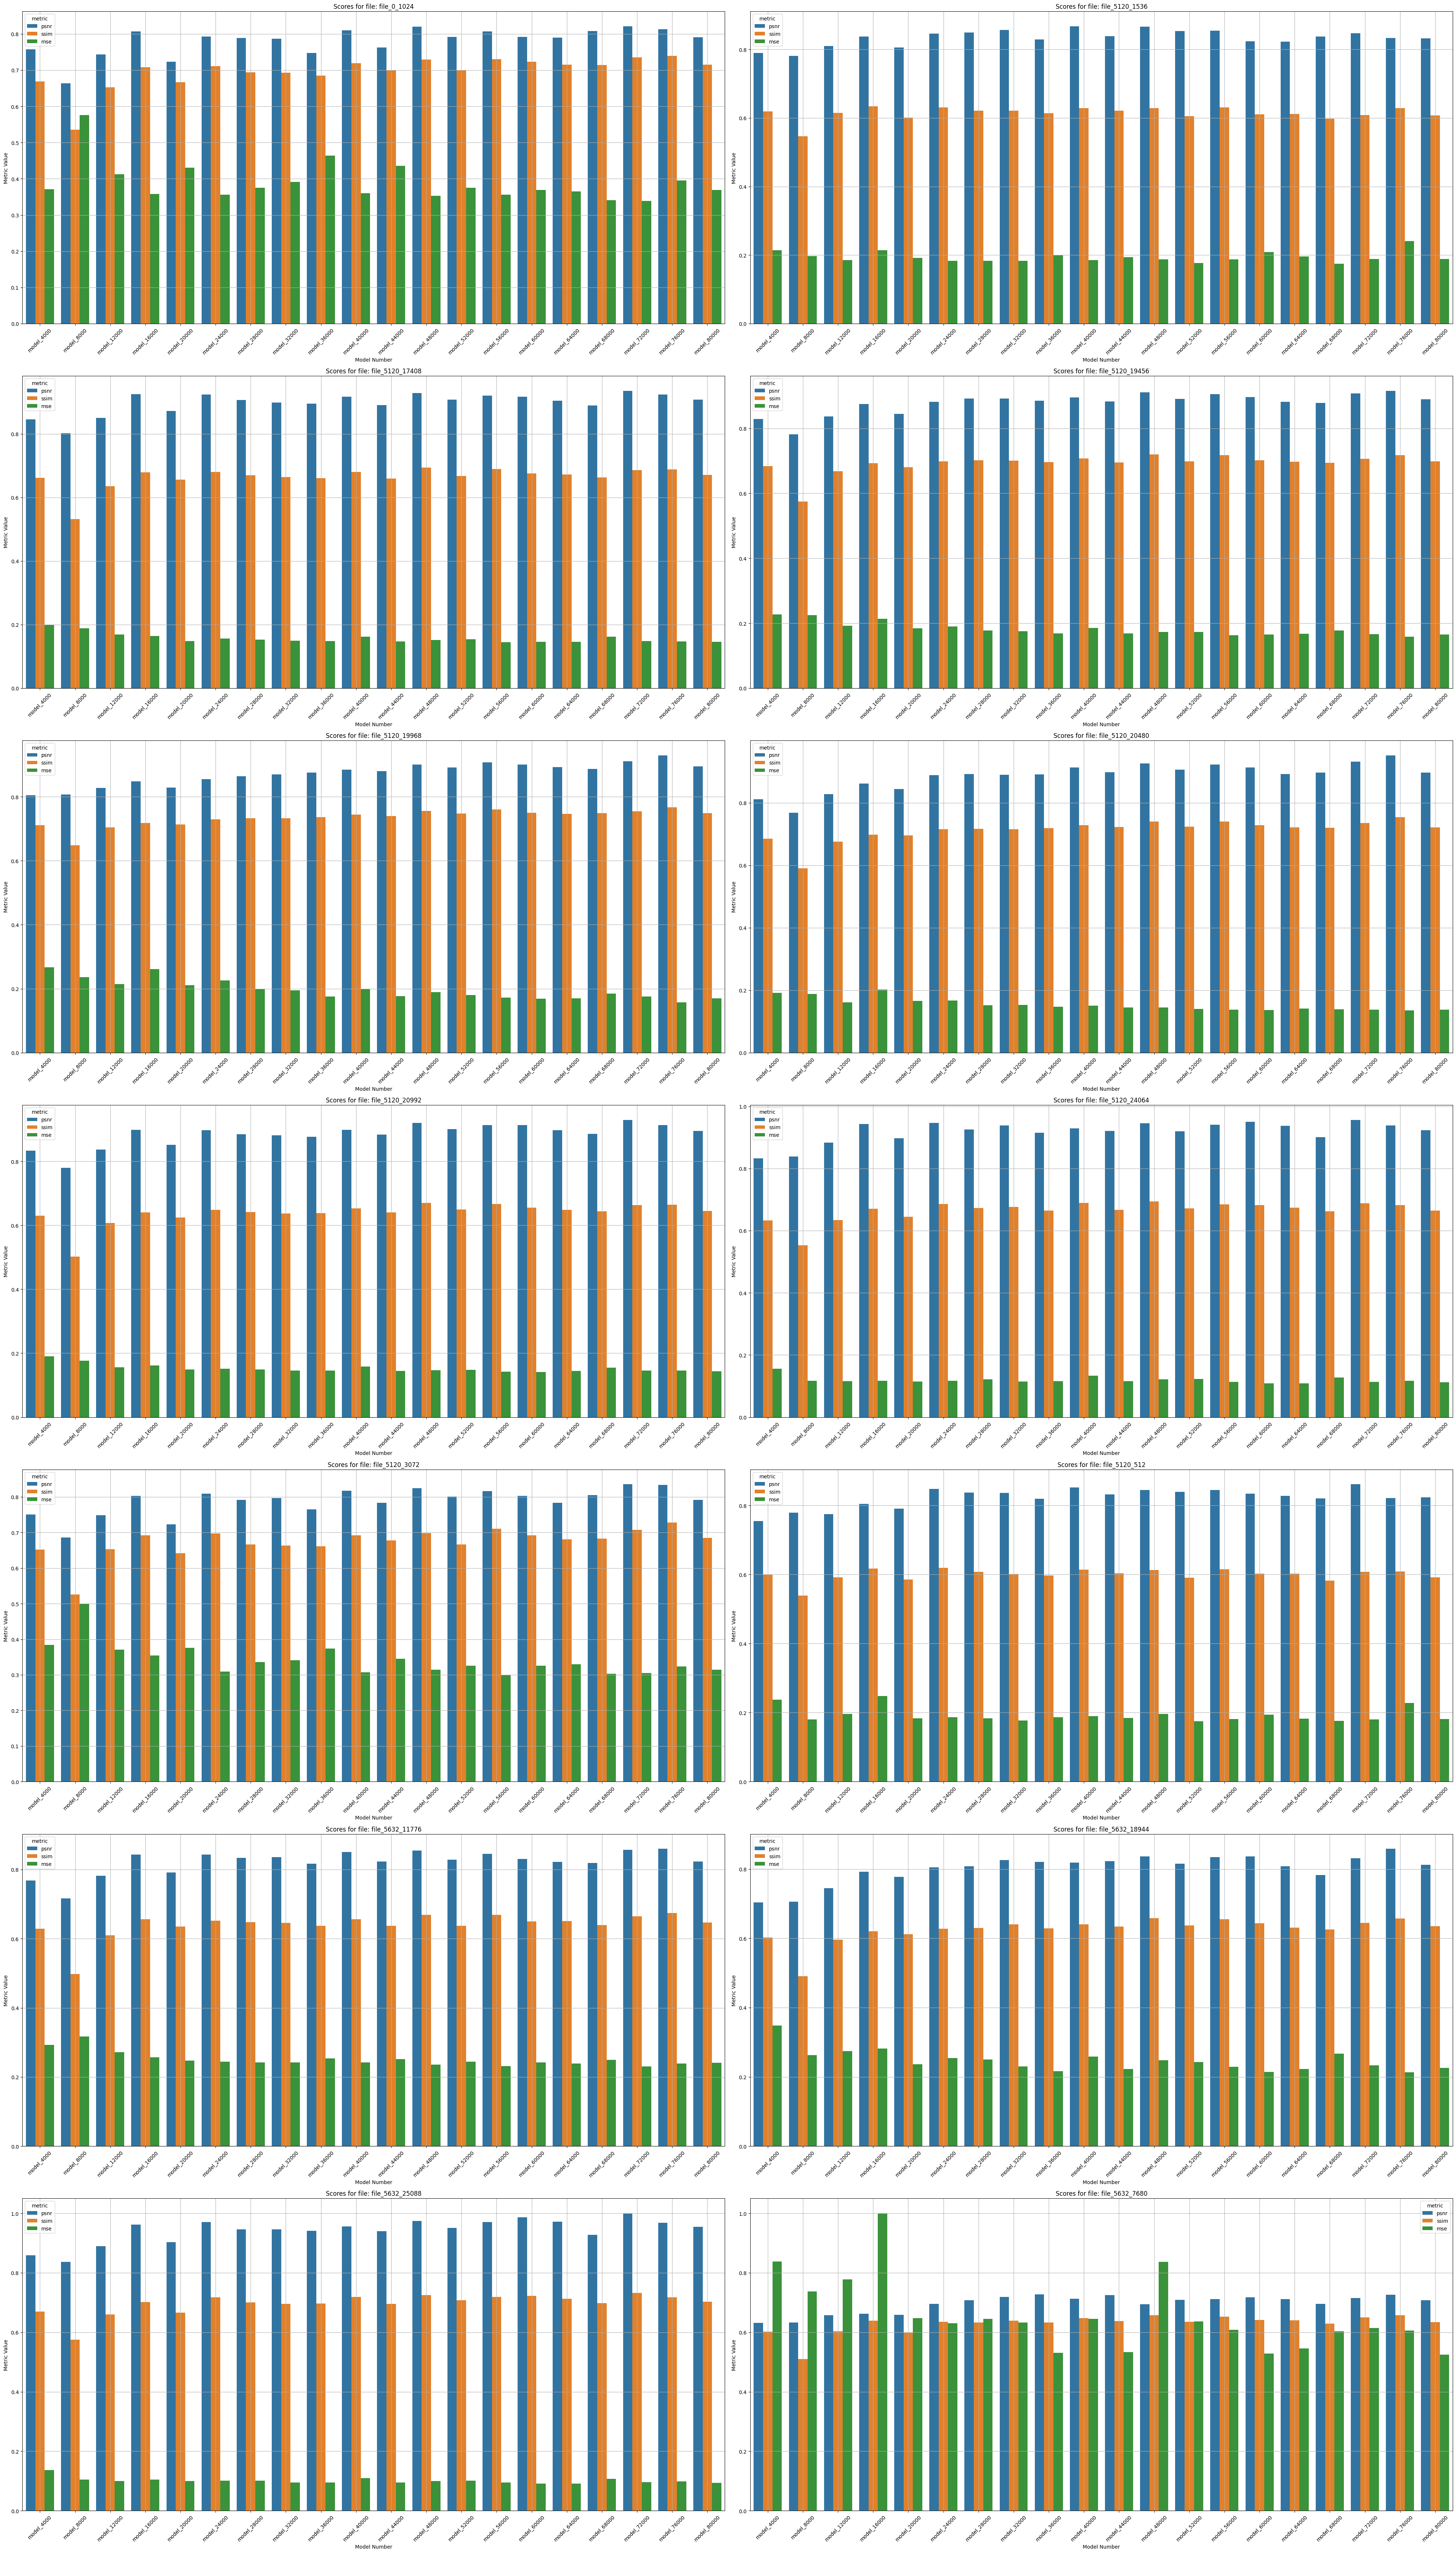

In [321]:
metricas_l1_loss = hd_loadfile.json_to_dict(path_L1_loss)[0]
print(
    "El mejor modelo en base a la optimizacion de las metricas es : ",
    calculate_best_model(metricas_l1_loss),
)

model_data = []
for name_model, data in metricas_l1_loss.items():
    temp_dict_uf = {}
    for items_metric in data:
        list_key_data = list(items_metric.keys())
        temp_dict_rst = {}
        temp_dict_rst = {
            "modelo": name_model,
            "file": list_key_data[0],
            list_key_data[1]: items_metric[list_key_data[1]],
            list_key_data[2]: items_metric[list_key_data[2]],
            list_key_data[3]: items_metric[list_key_data[3]],
        }

        model_data.append(temp_dict_rst)


charbo_pd = pd.DataFrame(model_data)
display(charbo_pd)

scale_col = ["psnr", "mse"]
for column in scale_col:
    charbo_pd[column] = charbo_pd[column] / charbo_pd[column].abs().max()

display(charbo_pd)

grouped = charbo_pd.groupby("file")
# Definir el número de filas y columnas para la cuadrícula
num_rows = 7  # Ajusta según el número de archivos
num_cols = 2  # Ajusta según el número de archivos

# Crear una figura con subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(40, 70))

# Iterar sobre cada grupo de 'file' y crear un gráfico en un subplot específico
row = 0
col = 0
for file, group in grouped:
    # Reshape los datos para que sean adecuados para seaborn
    group_melted = group.melt(
        id_vars=["modelo"],
        value_vars=["psnr", "ssim", "mse"],
        var_name="metric",
        value_name="value",
    )

    # Crear el gráfico de barras en el subplot correspondiente
    plto = sns.barplot(
        x="modelo", y="value", hue="metric", data=group_melted, ax=axes[row, col]
    )

    # Personalizar el gráfico
    axes[row, col].set_title(f"Scores for file: {file}")
    axes[row, col].set_xlabel("Model Number")
    axes[row, col].set_ylabel("Metric Value")
    axes[row, col].set_xticklabels(plto.get_xticklabels(), rotation=45)
    axes[row, col].grid()

    # Incrementar los índices de fila y columna
    col += 1
    if col >= num_cols:
        row += 1
        col = 0

# Ajustar el espaciado entre los subplots
plt.tight_layout()

# Mostrar la figura
plt.show()


## Metricas Uformer

In [80]:



metricas_uformer = hd_loadfile.json_to_dict(save_metric_)
mtc_uformer_dict = metricas_uformer[0]

metrics_transform = []
for itemp in mtc_uformer_dict["model"]:
    names_keys = list(itemp.keys())
    temp_dict_uf = {}
    temp_dict_uf = {
        "file": names_keys[0],
        names_keys[1]: itemp[names_keys[1]],
        names_keys[2]: itemp[names_keys[2]],
        names_keys[3]: itemp[names_keys[3]],
    }

    metrics_transform.append(temp_dict_uf)

pd_uformer = pd.DataFrame(metrics_transform)

display(pd_uformer)

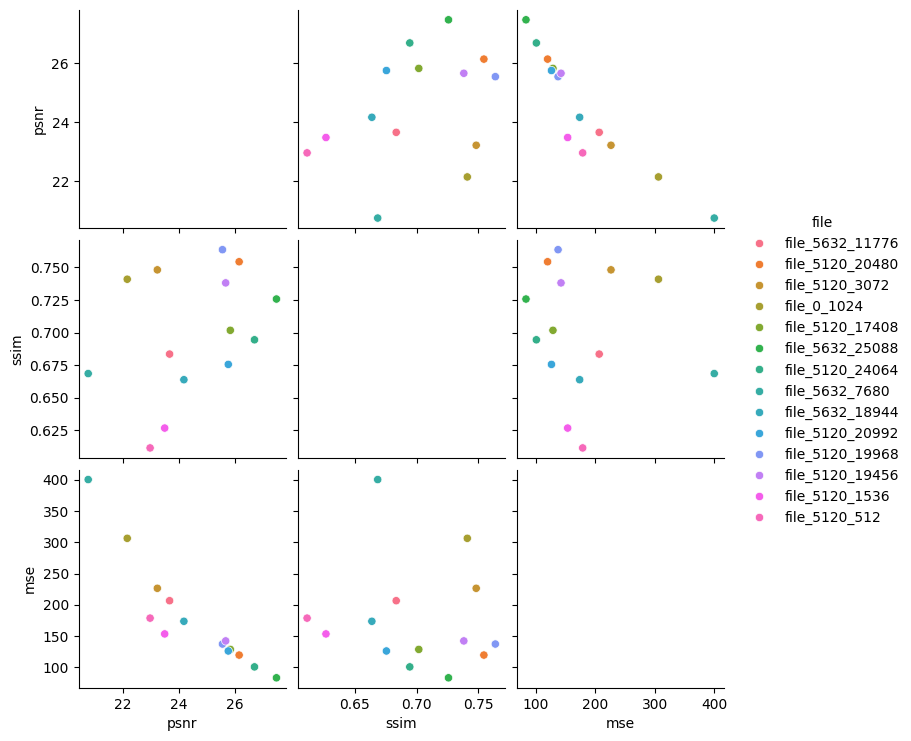

/tmp/ipykernel_128256/2078380806.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plto.set_xticklabels(plto.get_xticklabels(), rotation=45)


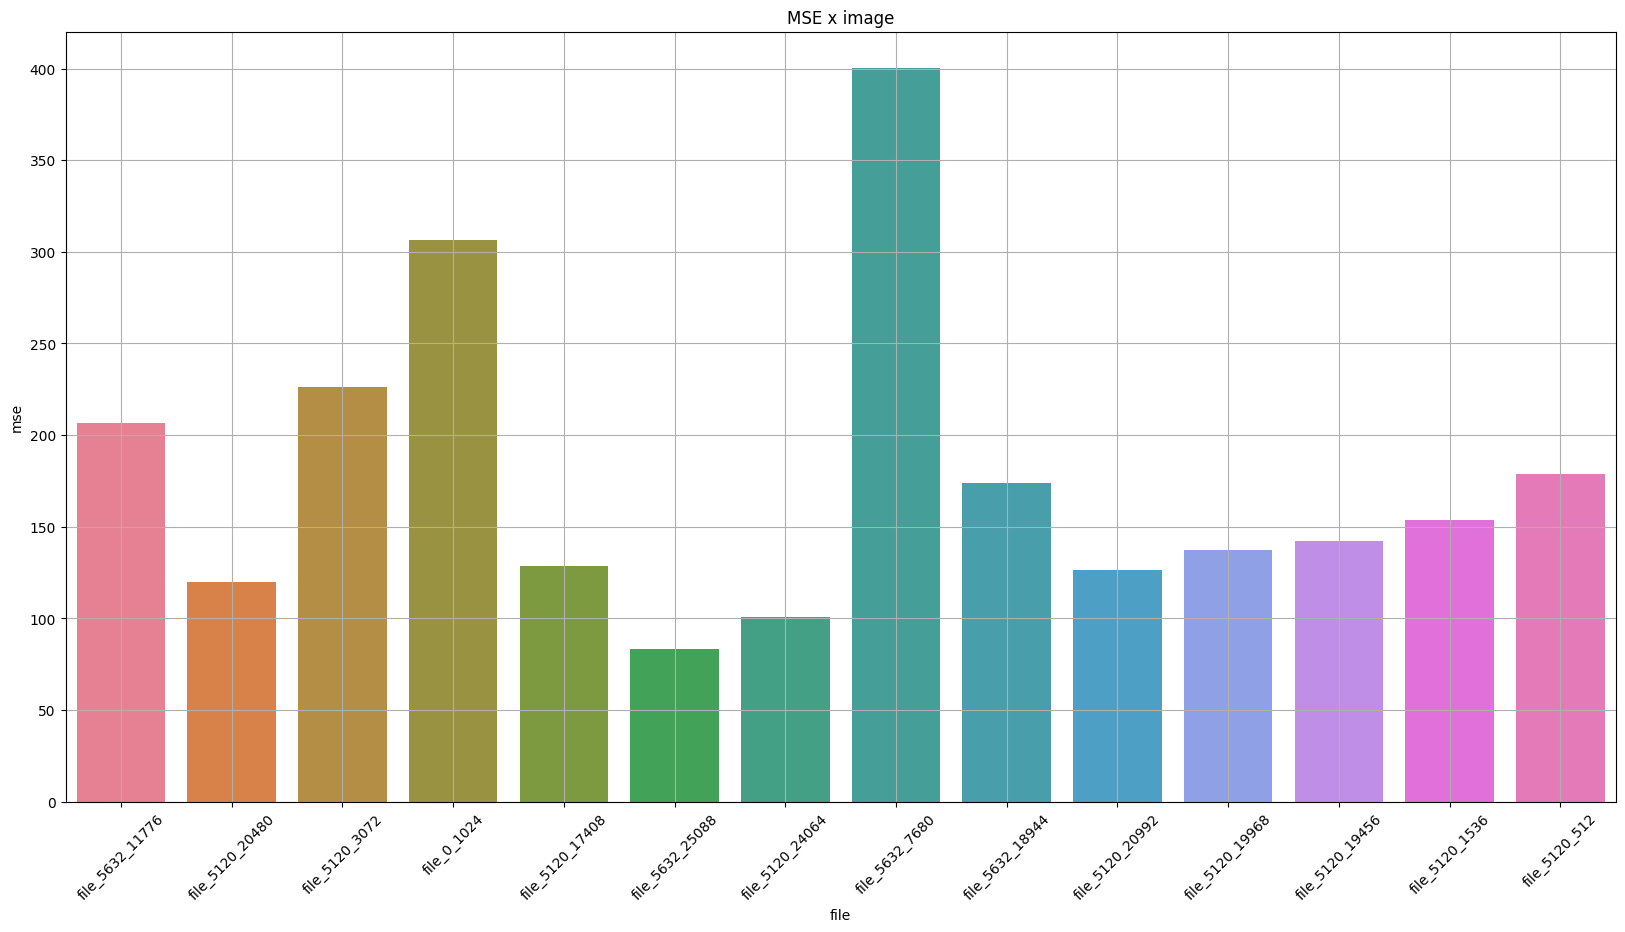

/tmp/ipykernel_128256/2078380806.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plto.set_xticklabels(plto.get_xticklabels(), rotation=45)


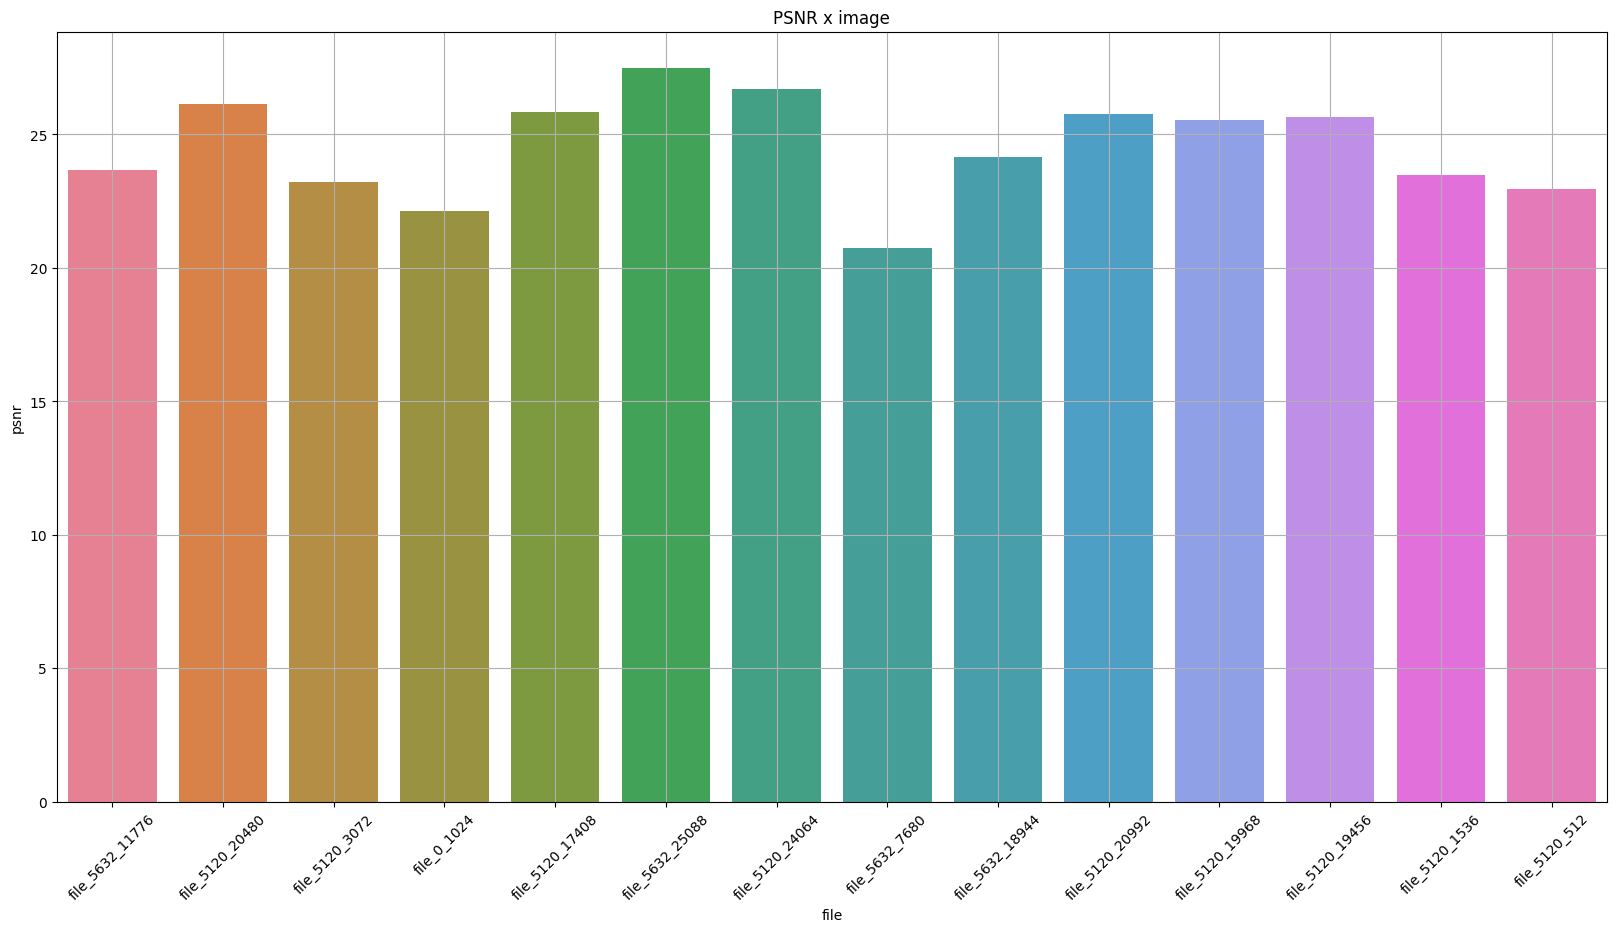

/tmp/ipykernel_128256/2078380806.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plto.set_xticklabels(plto.get_xticklabels(), rotation=45)


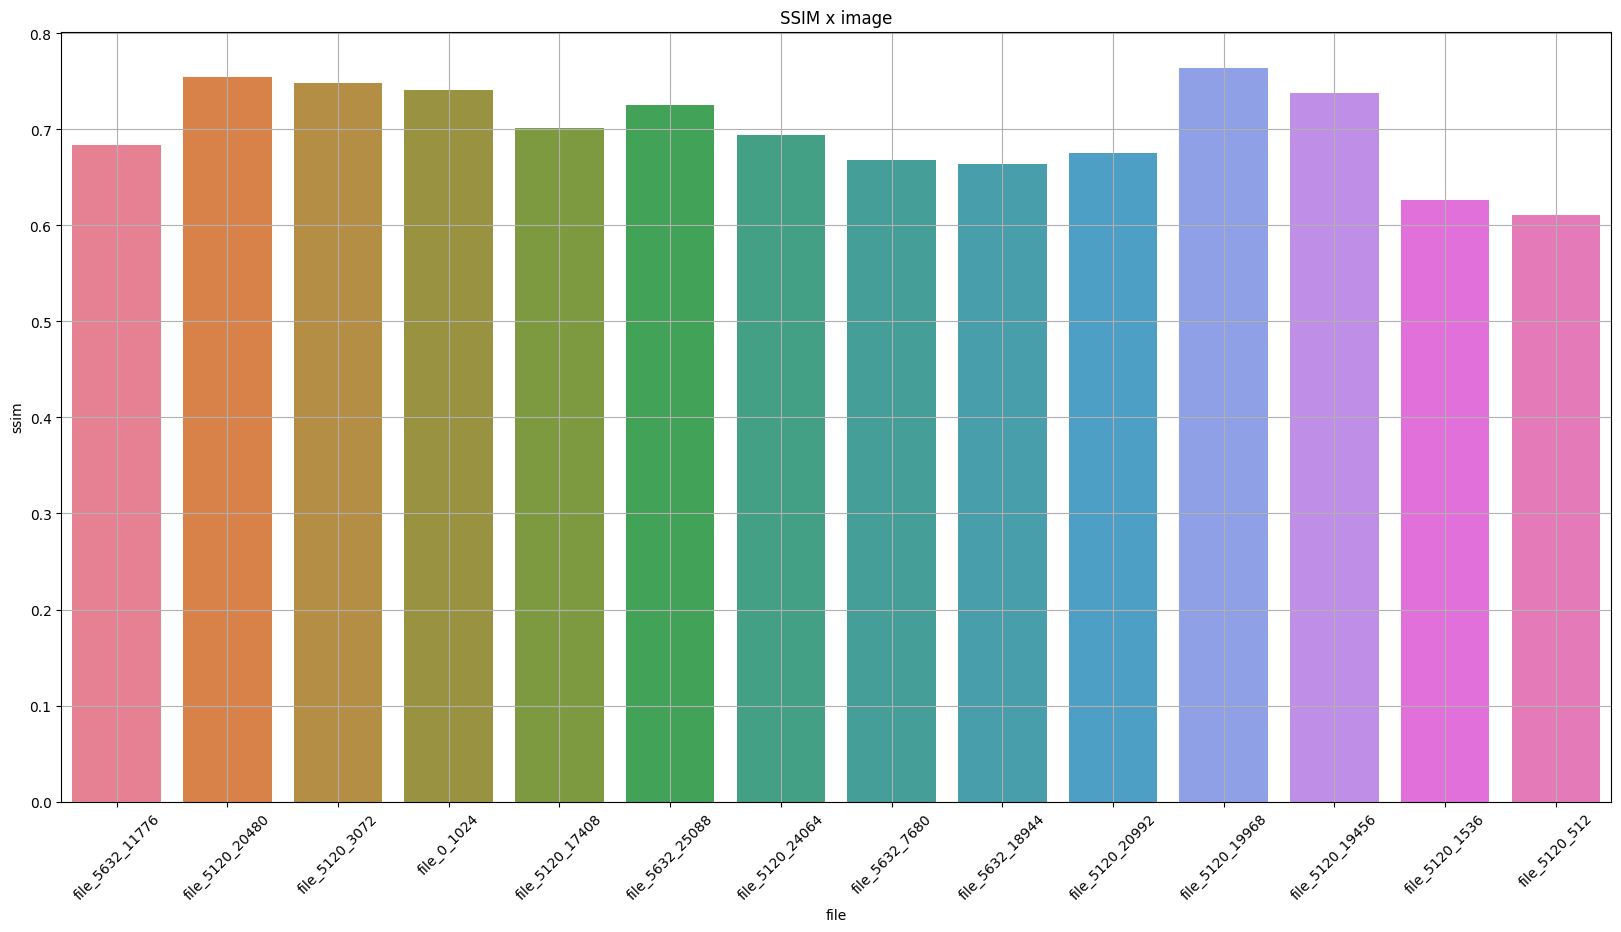

In [167]:
sns.pairplot(pd_uformer, hue="file")
plt.show()

plt.figure(figsize=(20, 10))
plto = sns.barplot(
    pd_uformer,
    x="file",
    y="mse",
    hue="file",
)
plto.set_xticklabels(plto.get_xticklabels(), rotation=45)
plt.title("MSE x image")
plt.grid()
plt.show()


plt.figure(figsize=(20, 10))
plto = sns.barplot(
    pd_uformer,
    x="file",
    y="psnr",
    hue="file",
)
plto.set_xticklabels(plto.get_xticklabels(), rotation=45)
plt.title("PSNR x image")
plt.grid()
plt.show()


plt.figure(figsize=(20, 10))
plto = sns.barplot(
    pd_uformer,
    x="file",
    y="ssim",
    hue="file",
)
plto.set_xticklabels(plto.get_xticklabels(), rotation=45)
plt.title("SSIM x image")
plt.grid()
plt.show()
